In [160]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn import set_config
set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
file = r'/home/alcatto/code/Al-Catto/project_sandbox/raw_data/WSC-variable_cross-check_v1.xlsx'
data = r'/home/alcatto/code/Al-Catto/project_sandbox/raw_data/wsc-dataset-0.2.0.csv'

In [4]:
df = pd.read_excel(file)
data_df = pd.read_csv(data)

In [5]:
data_df['nasal_cong_none'].fillna(0, inplace=True)

In [6]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]

In [7]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [8]:
data_df.isnull().sum().sort_values(ascending=False)/len(data_df)

psg_oxygen         0.997665
psg_cpap           0.935019
cigars_day         0.919844
bowls_day          0.917899
thyroid_problem    0.867704
                     ...   
nasal_cong_none    0.000000
awake_freq         0.000000
apnea_freq         0.000000
choke_freq         0.000000
waso               0.000000
Length: 134, dtype: float64

In [9]:
balance_cutoff = 0.9
imbalanced_classes = []
for col in data_df.columns:
    _ = data_df.columns.get_loc(col)
    if data_df.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
        imbalanced_classes.append((col, data_df.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

In [10]:
imbalanced_classes

[('race', array([0.95836576])),
 ('coronary_ynd', array([0.9233463])),
 ('angina_ynd', array([0.96730245])),
 ('atheroscl_ynd', array([0.9758661])),
 ('heartattack_ynd', array([0.95679253])),
 ('congestivehf_ynd', array([0.98871595])),
 ('coronarybypass_ynd', array([0.95525292])),
 ('stroke_ynd', array([0.97743191])),
 ('emphysema_ynd', array([0.97898833])),
 ('angioplasty_ynd', array([0.95758755])),
 ('pacemaker_ynd', array([0.99105058])),
 ('coronary_artery_stent_ynd', array([0.9766537])),
 ('asthma_med', array([0.92140078])),
 ('asthma_rescue_med', array([0.96031128])),
 ('asthma_control_med', array([0.93696498])),
 ('dep_maoi_med', array([0.99922179])),
 ('dep_tca_med', array([0.9766537])),
 ('htn_alpha_med', array([0.96264591])),
 ('htn_arb_med', array([0.93190661])),
 ('narcotics_med', array([0.9766537])),
 ('decongestants_med', array([0.95914397])),
 ('anxiety_med', array([0.92801556])),
 ('estrogen_med', array([0.93385214])),
 ('androgen_med', array([0.99688716])),
 ('progester

In [11]:
len(imbalanced_classes)

29

In [13]:
imbalanced_list = []
for classes in imbalanced_classes:
    imbalanced_list.append(classes[0])

In [14]:
data_df.drop(imbalanced_list, axis=1, inplace=True)
data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)

In [15]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [16]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [17]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df1 = pd.concat(frames, axis = 1, verify_integrity=True)

##drop original row names

data_df1.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

In [18]:
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,78.0,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,87.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,84.6,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
#y = data_df1.se
#X = data_df1.drop('se', axis=1)

In [20]:
# X

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,ptstl90,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,0.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,2.0,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,0.4,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,2.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,0.0,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## exploration of TSO target

(array([613., 343., 116.,  22.,  18.,   2.,   4.,   0.,   3.,   2.]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.]),
 <BarContainer object of 10 artists>)

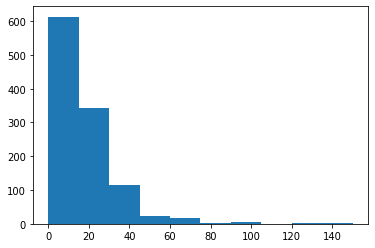

In [202]:
plt.hist(data_df1['tso'])

## sorting categoricals & targets

In [108]:
targets = ['tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds', 'waso', 'se', 'sleepiness'
          ]

In [114]:
numerics = ['creatinine', 'glucose', 'hdl', 'ldl','total_cholesterol', 'triglycerides', 'uric_acid', 'weightkg', 'bmi',
       'headcm', 'waist_girth1', 'waist_girth2', 'hip_girth1', 'hip_girth2',
       'neck_girth1', 'neck_girth2', 'sit_sys1', 'sit_dia1', 'sit_sys2',
       'sit_dia2', 'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam', 'zung_score', 'zung_index', 'state',
       'trait', 'beer_week', 'wine_week', 'hard_week', 'bowls_day', 'packs_week', 'cigars_day',
       'smoke_years', 'pack_years','workday', 'weekend',
       'naps', 'snore_freq',
       'num_pregnancies', 'ahi',
       'minsao2tst', 'ptstl90', 'age', 'heightcm', 'cans_cola', 'cups_coffee',
       'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq', 'ho_score'
           ]

In [164]:
categoricals = data_df1.drop(columns = numerics)
#categoricals = data_df1.drop(columns = targets)

In [165]:
ordinals = ['menopausal_status']

In [208]:
high_val_features = ['age',
 'weightkg',
 'bmi',
 'neck_girth1',
 'sit_sys1',
 'sit_dia1',
 'zung_score',
 'zung_index',
 'state',
 'trait',
 'caffeine',
 'hard_week',
 'alcohol_wk',
 'bowls_day',
 'packs_week',
 'cigars_day',
 'smoke_years',
 'pack_years',
 'eval_general',
 'eval_life',
 'eval_health',
 'workday',
 'weekend',
 'snore_freq',
 'snore_vol',
 'choke_freq',
 'apnea_freq']

In [211]:
#cross check high_val_features
data_df1[high_val_features]

,age,weightkg,bmi,neck_girth1,sit_sys1,sit_dia1,zung_score,zung_index,state,trait,...,pack_years,eval_general,eval_life,eval_health,workday,weekend,snore_freq,snore_vol,choke_freq,apnea_freq
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,52,85.5,27.6,39.5,112.0,78.0,24.0,30.00,20.0,24.0,...,0.000000,1,1,1,7.5,8.0,2.0,1,1,1
10191,50,73.0,25.3,31.5,132.0,84.0,31.0,38.75,27.4,24.0,...,0.000000,1,2,2,6.5,10.5,1.0,1,1,1
10198,57,115.5,46.9,39.5,142.0,88.0,30.0,37.50,25.3,28.0,...,47.142857,1,1,3,6.5,9.0,9.0,9,1,1
10226,55,79.2,26.5,39.5,128.0,76.0,34.0,42.50,37.9,36.0,...,78.000000,1,3,3,7.0,9.0,5.0,4,2,9
10241,51,100.6,34.4,42.0,140.0,88.0,31.0,38.75,21.1,25.0,...,1.142857,2,1,5,5.5,6.5,4.0,2,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,60,84.0,25.6,40.0,118.0,77.0,22.0,27.50,20.0,21.0,...,0.000000,1,1,2,6.0,8.0,2.0,2,1,1
99651,69,102.5,35.1,46.0,154.0,106.0,28.0,35.00,20.0,22.0,...,2.857143,1,1,2,7.0,7.0,5.0,4,9,9
99761,71,94.0,40.7,35.5,160.0,88.0,33.0,41.25,32.6,30.0,...,0.000000,1,1,2,7.5,9.0,5.0,3,9,9


## ac - TSO Linear Regression w/ Pipe

In [166]:
data_df1 = data_df1.fillna(0)

In [127]:
y = data_df1.tso
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [129]:
y.isna().sum().sum()

0

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [131]:
scaler = StandardScaler()

In [132]:
linreg = LinearRegression()

In [133]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [134]:
tso_lin_Reg = pipe.fit(X_train, y_train)

In [135]:
pipe.score(X_test, y_test)

-3.306134991685788

## ac - TSO Linear Regression w/o Pipe

In [250]:
y = data_df1.tso
X = data_df1[high_val_features]


In [254]:
X.columns

Index(['age', 'weightkg', 'bmi', 'neck_girth1', 'sit_sys1', 'sit_dia1',
       'zung_score', 'zung_index', 'state', 'trait', 'caffeine', 'hard_week',
       'alcohol_wk', 'bowls_day', 'packs_week', 'cigars_day', 'smoke_years',
       'pack_years', 'eval_general', 'eval_life', 'eval_health', 'workday',
       'weekend', 'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq'],
      dtype='object')

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [256]:
y_train.mean()

15.623515439429928

In [257]:
#X_train.select_dtypes(include=['float64', 'int64'])


In [258]:
X_train.columns

Index(['age', 'weightkg', 'bmi', 'neck_girth1', 'sit_sys1', 'sit_dia1',
       'zung_score', 'zung_index', 'state', 'trait', 'caffeine', 'hard_week',
       'alcohol_wk', 'bowls_day', 'packs_week', 'cigars_day', 'smoke_years',
       'pack_years', 'eval_general', 'eval_life', 'eval_health', 'workday',
       'weekend', 'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq'],
      dtype='object')

In [259]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [260]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,age,weightkg,bmi,neck_girth1,sit_sys1,sit_dia1,zung_score,zung_index,state,trait,...,pack_years,eval_general,eval_life,eval_health,workday,weekend,snore_freq,snore_vol,choke_freq,apnea_freq
0,-0.530477,-0.407288,0.162589,-1.153137,-0.953750,0.179758,-1.167563,-1.167563,-0.912022,-1.066675,...,-0.510135,-0.646451,-1.479021,-1.577682,-0.966179,0.243632,-0.811809,-1.000153,-0.474293,-0.704626
1,-0.652649,-0.770514,-0.459621,-0.917957,0.614015,1.765678,-0.162801,-0.162801,0.907382,0.178510,...,-0.510135,0.674694,-0.057405,0.807252,-0.022209,-0.597684,2.267215,1.706569,1.625993,-0.704626
2,1.179934,2.319261,1.393182,1.669025,1.940585,0.972718,0.554886,0.554886,-0.657840,-0.613881,...,0.592172,-0.646451,-0.057405,-0.385215,0.921761,0.243632,-0.371949,1.706569,-0.774333,-0.704626
3,-0.286132,0.078585,-0.349006,0.610714,0.614015,-0.613202,2.707948,2.707948,0.679957,1.989688,...,1.458270,1.995840,-0.057405,-0.385215,-1.438164,-1.439001,-0.811809,0.014868,-0.474293,1.583879
4,1.912966,0.455962,-0.141602,0.845895,-0.471361,-2.000882,0.124274,0.124274,-0.778242,0.404907,...,-0.510135,1.995840,1.364211,0.807252,-0.966179,-0.597684,0.507773,-0.323473,-0.774333,-0.704626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,-0.896993,1.210716,0.425300,1.198665,-0.833153,0.774478,0.698424,0.698424,0.492665,0.178510,...,-0.510135,0.674694,1.364211,0.807252,-0.022209,-1.439001,0.067912,-0.661813,-0.774333,-0.704626
838,-0.652649,-1.053547,-0.777639,-0.330006,-0.953750,-1.604402,-0.449876,-0.449876,-0.631084,0.518106,...,-0.510135,0.674694,-0.057405,-0.385215,-0.022209,0.243632,0.507773,-0.323473,-0.774333,-0.704626
839,1.057761,0.573892,0.314685,0.963485,-0.350763,-0.018482,-0.449876,-0.449876,-0.631084,-1.066675,...,-0.510135,-0.646451,-1.479021,0.807252,-0.966179,-1.439001,-0.371949,-0.661813,1.625993,1.583879
840,0.446901,-0.794100,-0.805293,-0.447597,0.131626,-0.414962,-1.167563,-1.167563,-0.912022,-0.727079,...,-0.510135,-0.646451,-0.057405,-0.385215,-0.022209,0.243632,-0.811809,-0.661813,-0.774333,-0.704626


In [261]:
data_df1.tso.max(),data_df1.tso.min(), data_df1.tso.mean()

(150.0, 0.0, 15.518254674977738)

In [262]:
model = LinearRegression()

In [263]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [266]:
model.score(X_test_scaled, y_test)

-0.17505267985339001

In [267]:
model.predict(X_test)
#model.coef_

array([-4.05365476e+01, -1.70999713e+01, -8.37941818e+01, -6.79181431e+01,
       -9.43443222e+01,  5.64841333e-02,  5.75504151e+01, -1.40690613e+02,
       -1.05921537e+02, -1.93636403e+01, -2.85488282e+01, -1.80610180e+01,
        1.88039780e+00, -6.29135393e+01,  7.49521504e+00,  3.56118617e+00,
       -4.04514928e+01,  7.67124337e+01, -6.70002353e+01, -3.80077691e+01,
       -5.02331893e+01, -1.05069563e+02, -1.11142995e+02, -8.31971027e+01,
       -8.10078680e+01, -3.30578919e+01, -1.94480634e+01, -2.00124915e+01,
       -8.18212059e+01,  6.83750444e+01, -8.38231469e+01, -1.04458224e+02,
        1.84751984e+01, -1.07618867e+02, -6.81048327e+01, -6.91618222e+01,
       -3.01207804e+01, -4.74805282e+01, -6.54331974e+01, -1.19054805e+02,
       -7.34651452e+00, -2.66591441e+01,  2.30960520e+01, -3.22092544e+01,
        1.31621543e+00,  6.60037400e+01, -4.66295475e+01, -2.05960069e+01,
       -9.53805832e+01, -6.14729780e+01, -5.67346376e+01, -4.65606866e+01,
       -3.94261265e+01, -

## ac - Linear Regression with Cross validation


In [155]:
y = data_df1.tso
X = data_df1.drop('tso', axis=1)

In [156]:
y = data_df1.tso
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [187]:
cv_results = cross_validate(LinearRegression(), X,y, cv=5, scoring='neg_mean_absolute_error')
cv_results['test_score'].mean()

-10.643965624552504

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [181]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [182]:
model = LinearRegression()

In [183]:
#cv_results = cross_validate(model, X_train_scaled,y_train, cv=5)

In [184]:
cv_results['test_score'].mean()

-0.03233778485792767